In [1]:
import numpy
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
import math
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Concatenate, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
 
# tensorflow.reset_default_graph()
tensorflow.random.set_seed(0)
# random.seed(0)
numpy.random.seed(0)

In [2]:
def create_dataset(dataset, look_back=14, day_offset=5):
    dataY= []
    dataX1=numpy.zeros([(len(dataset)-look_back),2,look_back])
    dataX2=numpy.zeros([(len(dataset)-look_back),2,look_back])
#     dataX3=numpy.zeros([(len(dataset)-look_back),2,look_back])
    
    #print(dataX.shape)
    for i in range(look_back,len(dataset)):
       # print(i)
        a = numpy.zeros([4,look_back])
        t1=dataset[(i-look_back):i, 0]
        t1=numpy.reshape(t1,[1,look_back])
        t4=dataset[(i-look_back):i, 48]
        t4=numpy.reshape(t4,[1,look_back])
        #print(t1.shape)
        t2=dataset[i, 48-look_back:48]
        t2=numpy.reshape(t2,[1,look_back])
        t6=dataset[i,-(look_back+3):-3]
        t6=numpy.reshape(t6,[1,look_back])
#         t3=numpy.zeros([1,look_back])
#         if i>=((day_offset+1)*7+look_back):
#             t3[0,0:day_offset]=[dataset[j,0] for j in range(i-(((day_offset+1)*7)+look_back),i-(look_back+7),7)]
#         t5=numpy.zeros([1,look_back])
#         if i>=((day_offset+1)*7+look_back):
#             t5[0,0:day_offset]=[dataset[j,48] for j in range(i-(((day_offset+1)*7)+look_back),i-(look_back+7),7)]
            
            
        #print(t2.shape)
        a[0,:] = t1
        a[1,:] = t4
        a[2,:] = t2
        a[3,:] = t6
#         a[4,:] = t3
#         a[5,:] = t5
        dataX1[i-look_back,:,:]=a[0:2,:]
        dataX2[i-look_back,:,:]=a[2:4,:]
#         dataX3[i-look_back,:,:]=a[4:,:]
#         a = numpy.concatenate([dataset[(i-look_back-7):i-7, 0], dataset[i,-14:]],axis=1)
        
        #dataX.append(a)
        dataY.append(dataset[i,-1])
    return numpy.array(dataX1),numpy.array(dataX2),numpy.array(dataY)

In [3]:
def missing_values(datarange, categorical=[]):  
    datarange= pd.DataFrame(datarange)
    if not categorical:
        meandata=datarange.mean()
        meandata=meandata.to_numpy()
    else:
        meandata=datarange.mean()
        meandata=meandata.to_numpy()
        
        modedata = datarange.mode()
        modedata = modedata.to_numpy()
        modedata = modedata[0,:]
        
        for i in categorical:
                meandata[i-1] = modedata[i]
                
    datetime_series = pd.to_datetime(datarange['fltdat'])
    miss_idx=pd.date_range(start = '01-01-2015', end = '31-12-2019' ).difference(datetime_series)
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    datarange=datarange.set_index(datetime_index)

    datarange.drop('fltdat',axis=1,inplace=True)
    newidx = pd.date_range('01-01-2015', '31-12-2019')
    datarange = datarange.reindex(newidx, fill_value=0)
    
    meandata=meandata.reshape(1,meandata.shape[0])
    dat = numpy.tile(meandata, [miss_idx.shape[0],1])
    datarange.loc[miss_idx]=dat
    return datarange

In [4]:
def mean_absolute_percentage_error(y_test, y_pred):
        import numpy as np
        t = np.array(y_test)
        p = np.array(y_pred)
        mae = list()
        mape = list()
        for i in range(len(t)):
            if (t[i] == 0):
                mae.append(abs(p[i]))
            else:
                mae.append(float(abs(t[i] - p[i])))
                mape.append(float(abs((t[i] - p[i])/t[i])))
        return np.mean(mae) , np.mean(mape)

In [5]:
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('data/rmscapfc.csv', parse_dates=['fltdat'],dayfirst=True)
print(dataframe.columns)
dataframe.drop(dataframe.columns[[2,3,4,6,8,9,10,56,57,58,59,60,61,62] ], axis=1, inplace=True)

dataframe2 = read_csv('data/rmscapy.csv', parse_dates=['fltdat'],dayfirst=True)
# print(dataframe2.columns)
f_column = dataframe2[["paxcnty", "dcp_51", "dcp_50", "dcp_49", "dcp_48", "dcp_47", "dcp_46",
       "dcp_45", "dcp_44", "dcp_43", "dcp_42", "dcp_41", "dcp_40", "dcp_39",
       "dcp_38", "dcp_37", "dcp_36", "dcp_35", "dcp_34", "dcp_33", "dcp_3",
       "dcp_31", "dcp_30", "dcp_29", "dcp_28", "dcp_27", "dcp_26", "dcp_25",
       "dcp_24", "dcp_23", "dcp_22", "dcp_21", "dcp_20", "dcp_19", "dcp_18",
       "dcp_17", "dcp_16", "dcp_15", "dcp_14", "dcp_13", "dcp_12", "dcp_11",
       "dcp_10", "dcp_9", "dcp_8"]]
 

dataframe = pd.concat([dataframe,f_column], axis = 1)
# print(dataframe.columns)
dataframe3 = read_csv('data/uldfc.csv', parse_dates=['fltdat'],dayfirst=True)

dataframe3.drop(dataframe3.columns[[1,2,3] ], axis=1, inplace=True)
dataframe4 = read_csv('data/uldy.csv', parse_dates=['fltdat'],dayfirst=True)
dataframe4.drop(dataframe4.columns[[1,2,3] ], axis=1, inplace=True)
f_column = dataframe4[["county"]]
dataframe3 = pd.concat([dataframe3,f_column], axis = 1)
print(dataframe.columns)

Index(['fltdat', 'paxcntfc', 'fltnum', 'legorg', 'legdst', 'acrtypcod',
       'keyidr', 'totpaylodwgt', 'totpaylodvol', 'totpaylodpos', 'totsetfc',
       'totpaxwgt', 'dp_51', 'dp_50', 'dp_49', 'dp_48', 'dp_47', 'dp_46',
       'dp_45', 'dp_44', 'dp_43', 'dp_42', 'dp_41', 'dp_40', 'dp_39', 'dp_38',
       'dp_37', 'dp_36', 'dp_35', 'dp_34', 'dp_33', 'dp_32', 'dp_31', 'dp_30',
       'dp_29', 'dp_28', 'dp_27', 'dp_26', 'dp_25', 'dp_24', 'dp_23', 'dp_22',
       'dp_21', 'dp_20', 'dp_19', 'dp_18', 'dp_17', 'dp_16', 'dp_15', 'dp_14',
       'dp_13', 'dp_12', 'dp_11', 'dp_10', 'dp_9', 'dp_8', 'dp_7', 'dp_6',
       'dp_5', 'dp_4', 'dp_3', 'dp_2', 'dp_1'],
      dtype='object')
Index(['fltdat', 'paxcntfc', 'acrtypcod', 'totpaylodwgt', 'totpaxwgt', 'dp_51',
       'dp_50', 'dp_49', 'dp_48', 'dp_47', 'dp_46', 'dp_45', 'dp_44', 'dp_43',
       'dp_42', 'dp_41', 'dp_40', 'dp_39', 'dp_38', 'dp_37', 'dp_36', 'dp_35',
       'dp_34', 'dp_33', 'dp_32', 'dp_31', 'dp_30', 'dp_29', 'dp_28', 'dp_27',

In [6]:
NUM=[0,1825,1825,1817,1816,1812,1821,1825,1824,1819,1825,1825,1824,1826,1819,1825,1822,1823,1813, 1826, 1820]
NUMuld=[0,1817,1574,1808,1802,1807,1808,1730,1817,1385,1820,1816,1606,1819,1810,1817,421,1813,434,1532,1814]
cat_inp=[2]

In [7]:
# dataset, datasetY = numpy.empty([1805,3,look_back]), []
for i in range(0,len(NUM)-1):
#     print(i)
    datasub = dataframe.iloc[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
#     datasub=datasetall[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
    datasub = missing_values(datasub, cat_inp)
    datasub = datasub.values
    datasub = datasub.astype('float32')
    
    datasubuld = dataframe3.iloc[sum(NUMuld[0:i+1]):sum(NUMuld[0:i+2]),:]
#     datasub=datasetall[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
    datasubuld = missing_values(datasubuld)
    datasubuld = datasubuld.values
    datasubuld = datasubuld.astype('float32')
    
    datasub = numpy.concatenate([datasub, datasubuld], axis=1)
    if i==0:
        data = datasub
    else:
        data = numpy.concatenate([data, datasub], axis =0)
 

C:\Users\iist\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  import sys
C:\Users\iist\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.


In [8]:
out = data[:,2] - data[:,3] - (data[:,-1]*data[:,-2]*114)
out = out.reshape(out.shape[0],1)
data = numpy.concatenate([data,out], axis=1)
print(data.shape)

(36520, 96)


In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

In [10]:
def sequence_data_build(data, look_back):
    for i in range(0,20):
        datasub = data[i*1826:((i+1)*1826),:]
        X1, X2, Y = create_dataset(datasub, look_back)
        Y = Y.reshape(Y.shape[0],1)
        if i==0: 
            data_LSTM_X1, data_LSTM_X2 = X1, X2
            data_LSTM_Y = Y
        else:
            data_LSTM_X1,data_LSTM_X2 = numpy.concatenate([data_LSTM_X1, X1],axis=0), numpy.concatenate([data_LSTM_X2, X2],axis=0)  
            data_LSTM_Y = numpy.concatenate([data_LSTM_Y, Y],axis=0)
    return data_LSTM_X1,data_LSTM_X2,data_LSTM_Y

In [11]:
def train_test_build(X, Y, m1, m2):
    spliter = int(X.shape[0]/20)
    tot_len = m1
    train_len = m2
    for i in range(0,20):
        Xsub = X[i*spliter:((i+1)*spliter),:]
        Ysub = Y[i*spliter:((i+1)*spliter)]
        if i==0:
            trainX = Xsub[0:m2,:]
            testX = Xsub[m2:m1,:]
            trainY = Ysub[0:m2]
            testY = Ysub[m2:m1]
        else:
            trainX = numpy.concatenate([trainX, Xsub[0:m2,:]], axis=0)
            testX = numpy.concatenate([testX, Xsub[m2:m1,:]], axis=0)
            trainY = numpy.concatenate([trainY, Ysub[0:m2]], axis=0)
            testY = numpy.concatenate([testY, Ysub[m2:m1]], axis=0)
        
    return trainX, trainY, testX, testY

In [12]:
def model_build(trainX1, trainX2, testX1, testX2, trainY, testY, units, saving =False, month=None, EarlyStop = False):
    
    if EarlyStop:
        callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                            mode = 'min', restore_best_weights=True)
    
    inp1 = Input(shape=(2, trainX1.shape[2]))
    inp2 = Input(shape=(2, trainX2.shape[2]))
#     inp3 = Input(shape=(2, trainX3.shape[2]))

    LS1 = LSTM(units, input_shape=(2, trainX1.shape[2]))
    out1 = LS1(inp1)
    LS2 = LSTM(units, input_shape=(2, trainX2.shape[2]))
    out2 = LS2(inp2)
#     LS3 = LSTM(units, input_shape=(2, trainX3.shape[2]))
#     out3 = LS3(inp3)

    mrg = Concatenate(axis=1)([out1,out2])
    op = Dense(1)(mrg)

    model = Model(inputs=[inp1, inp2], outputs=op)
#     model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    if EarlyStop:
        history =model.fit([trainX1, trainX2], trainY, epochs=100, batch_size=150, 
                           validation_data=([testX1,testX2], testY),verbose=1,callbacks=[callback])
    else:
        history =model.fit([trainX1, trainX2], trainY, epochs=100, batch_size=150, 
                           validation_data=([testX1,testX2], testY),verbose=1)
                
    testPredict = model.predict([testX1,testX2])
                
    sh = testPredict.shape
    inv_yhat = testPredict.reshape(sh[0]*sh[1],1)
    inv_yhat = numpy.concatenate([ data[0:inv_yhat.shape[0],0:95], inv_yhat], axis=1)

    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]
    testY = testY.reshape(sh[0]*sh[1],1)
 
    inv_y = numpy.concatenate([data[0:testY.shape[0],0:95], testY], axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]
             
    rmse = numpy.sqrt(mean_squared_error(inv_y, inv_yhat))
    mae, mape = mean_absolute_percentage_error(inv_y, inv_yhat) 
    r2 = r2_score(inv_y, inv_yhat)
    
    res=[]
    if saving:
        inv_y = inv_y.reshape(inv_y.shape[0],1) 
        inv_yhat = inv_yhat.reshape(inv_yhat.shape[0],1) 
        res = numpy.concatenate([inv_y, inv_yhat], axis=1)
        df = pd.DataFrame(res)
        res = df.to_csv("pm2f_" + month + ".csv", index = False)
    return rmse, mape,mae,r2, history

In [15]:
def cross_validation(lag_vec = [7,14,21,28], units_vec = [2,4,8,16,32,64,128]):
    results = numpy.zeros([4,3,len(lag_vec),len(units_vec)])
    
    for folds in range(0,3):
        for i in range(0,len(lag_vec)):
            data_LSTM_X1,data_LSTM_X2,data_LSTM_Y = sequence_data_build(data, lag_vec[i])
            totday = int(data_LSTM_X1.shape[0]/20)
            m1 = [totday-152, totday-121, totday-91, ]
            m2 = [m1[0]-31, m1[1]-31, m1[2]-30, ]
            lag = lag_vec[i]
            trainX1, trainY, testX1, testY= train_test_build(data_LSTM_X1, data_LSTM_Y, m1[folds], m2[folds])
            trainX2, trainY, testX2, testY= train_test_build(data_LSTM_X2, data_LSTM_Y, m1[folds], m2[folds])
#             trainX3, trainY, testX3, testY= train_test_build(data_LSTM_X3, data_LSTM_Y, m1[folds], m2[folds])
            testYcopy=testY
            for j in range(0, len(units_vec)):
                print(" ")
                print(" ")
                print(" ")
                print("------------------------------------------------")
                print("fold: {0}, lag: {1}, units: {2}".format(folds, lag_vec[i], units_vec[j]))
                units = units_vec[j]
                rmse, mape, mae, r2, his = model_build(trainX1, trainX2, testX1, testX2, trainY, testY, units, EarlyStop=True) 
                results[0,folds,i,j] = rmse 
                results[2,folds,i,j], results[1,folds,i,j] = mae, mape
                results[3,folds,i,j] = r2
    return results        

In [16]:
lag_vec = [7,14]
units_vec = [2,4,8,16,32,64,128]
results = cross_validation(lag_vec, units_vec)


 
 
 
------------------------------------------------
fold: 0, lag: 7, units: 2
Train on 32720 samples, validate on 620 samples
Epoch 1/100
32720/32720 [==============================] - 7s 218us/sample - loss: 0.2108 - val_loss: 0.1549
Epoch 2/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.1777 - val_loss: 0.1413
Epoch 3/100
32720/32720 [==============================] - 2s 64us/sample - loss: 0.1633 - val_loss: 0.1296
Epoch 4/100
32720/32720 [==============================] - 2s 70us/sample - loss: 0.1480 - val_loss: 0.1159
Epoch 5/100
32720/32720 [==============================] - 2s 66us/sample - loss: 0.1379 - val_loss: 0.1060
Epoch 6/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.1329 - val_loss: 0.1027
Epoch 7/100
32720/32720 [==============================] - 2s 67us/sample - loss: 0.1292 - val_loss: 0.1010
Epoch 8/100
32720/32720 [==============================] - 2s 66us/sample - loss: 0.1263 - val_loss: 0.0997
Epoch 

32720/32720 [==============================] - 2s 69us/sample - loss: 0.1093 - val_loss: 0.0823
Epoch 76/100
32720/32720 [==============================] - 2s 69us/sample - loss: 0.1093 - val_loss: 0.0835
Epoch 77/100
32720/32720 [==============================] - 2s 71us/sample - loss: 0.1092 - val_loss: 0.0837
Epoch 78/100
32720/32720 [==============================] - 2s 70us/sample - loss: 0.1091 - val_loss: 0.0818
Epoch 79/100
32720/32720 [==============================] - 2s 69us/sample - loss: 0.1090 - val_loss: 0.0819
Epoch 80/100
32720/32720 [==============================] - 2s 72us/sample - loss: 0.1090 - val_loss: 0.0824
Epoch 81/100
32720/32720 [==============================] - 2s 71us/sample - loss: 0.1089 - val_loss: 0.0813
Epoch 82/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.1088 - val_loss: 0.0826
Epoch 83/100
32720/32720 [==============================] - 3s 77us/sample - loss: 0.1087 - val_loss: 0.0821
Epoch 84/100
32720/32720 [======

32720/32720 [==============================] - 2s 69us/sample - loss: 0.1109 - val_loss: 0.0863
Epoch 50/100
32720/32720 [==============================] - 2s 65us/sample - loss: 0.1108 - val_loss: 0.0922
Epoch 51/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.1108 - val_loss: 0.0907
Epoch 52/100
32720/32720 [==============================] - 2s 64us/sample - loss: 0.1105 - val_loss: 0.0881
Epoch 53/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.1104 - val_loss: 0.0842
Epoch 54/100
32720/32720 [==============================] - 2s 71us/sample - loss: 0.1104 - val_loss: 0.0861
Epoch 55/100
32720/32720 [==============================] - 2s 65us/sample - loss: 0.1102 - val_loss: 0.0865
Epoch 56/100
32720/32720 [==============================] - 2s 66us/sample - loss: 0.1100 - val_loss: 0.0856
Epoch 57/100
32720/32720 [==============================] - 2s 67us/sample - loss: 0.1100 - val_loss: 0.0839
Epoch 58/100
32720/32720 [======

32720/32720 [==============================] - 2s 68us/sample - loss: 0.1107 - val_loss: 0.0875
Epoch 36/100
32720/32720 [==============================] - 2s 70us/sample - loss: 0.1104 - val_loss: 0.0836
Epoch 37/100
32720/32720 [==============================] - 2s 71us/sample - loss: 0.1101 - val_loss: 0.0847
Epoch 38/100
32720/32720 [==============================] - 2s 69us/sample - loss: 0.1100 - val_loss: 0.0860
Epoch 39/100
32720/32720 [==============================] - 2s 69us/sample - loss: 0.1097 - val_loss: 0.0822
Epoch 40/100
32720/32720 [==============================] - 2s 72us/sample - loss: 0.1095 - val_loss: 0.0828
Epoch 41/100
32720/32720 [==============================] - 2s 67us/sample - loss: 0.1095 - val_loss: 0.0876
Epoch 42/100
32720/32720 [==============================] - 2s 69us/sample - loss: 0.1091 - val_loss: 0.0826
Epoch 43/100
32720/32720 [==============================] - 2s 72us/sample - loss: 0.1089 - val_loss: 0.0831
Epoch 44/100
32720/32720 [======

32720/32720 [==============================] - 2s 63us/sample - loss: 0.1177 - val_loss: 0.1007
Epoch 10/100
32720/32720 [==============================] - 2s 64us/sample - loss: 0.1174 - val_loss: 0.0974
Epoch 11/100
32720/32720 [==============================] - 2s 66us/sample - loss: 0.1170 - val_loss: 0.0954
Epoch 12/100
32720/32720 [==============================] - 2s 70us/sample - loss: 0.1163 - val_loss: 0.0965
Epoch 13/100
32720/32720 [==============================] - 2s 65us/sample - loss: 0.1158 - val_loss: 0.0907
Epoch 14/100
32720/32720 [==============================] - 2s 66us/sample - loss: 0.1155 - val_loss: 0.0951
Epoch 15/100
32720/32720 [==============================] - 2s 70us/sample - loss: 0.1153 - val_loss: 0.0929
Epoch 16/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.1147 - val_loss: 0.0944
Epoch 17/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.1145 - val_loss: 0.0938
Epoch 18/100
32720/32720 [======

32720/32720 [==============================] - 2s 69us/sample - loss: 0.1138 - val_loss: 0.0941
Epoch 18/100
32720/32720 [==============================] - 2s 63us/sample - loss: 0.1132 - val_loss: 0.0942
 
 
 
------------------------------------------------
fold: 0, lag: 7, units: 64
Train on 32720 samples, validate on 620 samples
Epoch 1/100
32720/32720 [==============================] - 7s 203us/sample - loss: 0.1439 - val_loss: 0.1020
Epoch 2/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.1246 - val_loss: 0.1086
Epoch 3/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.1219 - val_loss: 0.0993
Epoch 4/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.1216 - val_loss: 0.1035
Epoch 5/100
32720/32720 [==============================] - 2s 61us/sample - loss: 0.1201 - val_loss: 0.1048
Epoch 6/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.1193 - val_loss: 0.0945
Epoch 7/100
3272

32720/32720 [==============================] - 2s 61us/sample - loss: 0.0967 - val_loss: 0.0657
Epoch 74/100
32720/32720 [==============================] - 2s 67us/sample - loss: 0.0966 - val_loss: 0.0625
Epoch 75/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.0965 - val_loss: 0.0635
Epoch 76/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.0968 - val_loss: 0.0641
Epoch 77/100
32720/32720 [==============================] - 2s 69us/sample - loss: 0.0963 - val_loss: 0.0649
Epoch 78/100
32720/32720 [==============================] - 2s 66us/sample - loss: 0.0964 - val_loss: 0.0619
Epoch 79/100
32720/32720 [==============================] - 2s 65us/sample - loss: 0.0963 - val_loss: 0.0619
Epoch 80/100
32720/32720 [==============================] - 2s 68us/sample - loss: 0.0964 - val_loss: 0.0612
Epoch 81/100
32720/32720 [==============================] - 2s 67us/sample - loss: 0.0963 - val_loss: 0.0636
Epoch 82/100
32720/32720 [======

32720/32720 [==============================] - 2s 67us/sample - loss: 0.0977 - val_loss: 0.0620
Epoch 50/100
32720/32720 [==============================] - 2s 66us/sample - loss: 0.0975 - val_loss: 0.0708
Epoch 51/100
32720/32720 [==============================] - 2s 67us/sample - loss: 0.0974 - val_loss: 0.0641
Epoch 52/100
32720/32720 [==============================] - 2s 69us/sample - loss: 0.0972 - val_loss: 0.0686
Epoch 53/100
32720/32720 [==============================] - 2s 69us/sample - loss: 0.0971 - val_loss: 0.0624
Epoch 54/100
32720/32720 [==============================] - 2s 66us/sample - loss: 0.0973 - val_loss: 0.0657
Epoch 55/100
32720/32720 [==============================] - 2s 67us/sample - loss: 0.0970 - val_loss: 0.0635
Epoch 56/100
32720/32720 [==============================] - 2s 67us/sample - loss: 0.0968 - val_loss: 0.0621
Epoch 57/100
32720/32720 [==============================] - 2s 72us/sample - loss: 0.0968 - val_loss: 0.0685
Epoch 58/100
32720/32720 [======

32580/32580 [==============================] - 2s 72us/sample - loss: 0.1037 - val_loss: 0.0772
Epoch 65/100
32580/32580 [==============================] - 2s 71us/sample - loss: 0.1036 - val_loss: 0.0792
Epoch 66/100
32580/32580 [==============================] - 2s 68us/sample - loss: 0.1034 - val_loss: 0.0756
Epoch 67/100
32580/32580 [==============================] - 2s 71us/sample - loss: 0.1034 - val_loss: 0.0787
Epoch 68/100
32580/32580 [==============================] - 2s 70us/sample - loss: 0.1033 - val_loss: 0.0768
Epoch 69/100
32580/32580 [==============================] - 2s 69us/sample - loss: 0.1032 - val_loss: 0.0766
Epoch 70/100
32580/32580 [==============================] - 2s 70us/sample - loss: 0.1031 - val_loss: 0.0774
Epoch 71/100
32580/32580 [==============================] - 2s 68us/sample - loss: 0.1029 - val_loss: 0.0771
Epoch 72/100
32580/32580 [==============================] - 2s 72us/sample - loss: 0.1029 - val_loss: 0.0765
Epoch 73/100
32580/32580 [======

32580/32580 [==============================] - 2s 67us/sample - loss: 0.1057 - val_loss: 0.0849
Epoch 41/100
32580/32580 [==============================] - 2s 68us/sample - loss: 0.1055 - val_loss: 0.0847
Epoch 42/100
32580/32580 [==============================] - 2s 67us/sample - loss: 0.1055 - val_loss: 0.0826
Epoch 43/100
32580/32580 [==============================] - 2s 67us/sample - loss: 0.1054 - val_loss: 0.0857
Epoch 44/100
32580/32580 [==============================] - 2s 64us/sample - loss: 0.1052 - val_loss: 0.0872
Epoch 45/100
32580/32580 [==============================] - 2s 71us/sample - loss: 0.1050 - val_loss: 0.0829
Epoch 46/100
32580/32580 [==============================] - 2s 68us/sample - loss: 0.1048 - val_loss: 0.0873
Epoch 47/100
32580/32580 [==============================] - 2s 69us/sample - loss: 0.1049 - val_loss: 0.0844
Epoch 48/100
32580/32580 [==============================] - 2s 69us/sample - loss: 0.1048 - val_loss: 0.0849
Epoch 49/100
32580/32580 [======

32580/32580 [==============================] - 2s 67us/sample - loss: 0.1052 - val_loss: 0.0833
Epoch 22/100
32580/32580 [==============================] - 2s 70us/sample - loss: 0.1048 - val_loss: 0.0834
Epoch 23/100
32580/32580 [==============================] - 2s 66us/sample - loss: 0.1045 - val_loss: 0.0878
Epoch 24/100
32580/32580 [==============================] - 2s 69us/sample - loss: 0.1042 - val_loss: 0.0799
Epoch 25/100
32580/32580 [==============================] - 2s 69us/sample - loss: 0.1038 - val_loss: 0.0850
Epoch 26/100
32580/32580 [==============================] - 2s 70us/sample - loss: 0.1033 - val_loss: 0.0804
Epoch 27/100
32580/32580 [==============================] - 2s 71us/sample - loss: 0.1031 - val_loss: 0.0816
Epoch 28/100
32580/32580 [==============================] - 2s 71us/sample - loss: 0.1036 - val_loss: 0.0854
 
 
 
------------------------------------------------
fold: 0, lag: 14, units: 32
Train on 32580 samples, validate on 620 samples
Epoch 1/10

Epoch 2/100
32580/32580 [==============================] - 2s 70us/sample - loss: 0.1181 - val_loss: 0.0969
Epoch 3/100
32580/32580 [==============================] - 2s 71us/sample - loss: 0.1161 - val_loss: 0.1060
Epoch 4/100
32580/32580 [==============================] - 2s 65us/sample - loss: 0.1156 - val_loss: 0.1012
Epoch 5/100
32580/32580 [==============================] - 2s 67us/sample - loss: 0.1142 - val_loss: 0.0972
Epoch 6/100
32580/32580 [==============================] - 2s 70us/sample - loss: 0.1131 - val_loss: 0.0868
Epoch 7/100
32580/32580 [==============================] - 2s 69us/sample - loss: 0.1128 - val_loss: 0.0955
Epoch 8/100
32580/32580 [==============================] - 2s 68us/sample - loss: 0.1118 - val_loss: 0.0997
Epoch 9/100
32580/32580 [==============================] - 2s 72us/sample - loss: 0.1112 - val_loss: 0.0915
Epoch 10/100
32580/32580 [==============================] - 2s 66us/sample - loss: 0.1107 - val_loss: 0.0826
Epoch 11/100
32580/32580 [=

32580/32580 [==============================] - 7s 226us/sample - loss: 0.1354 - val_loss: 0.0936
Epoch 2/100
32580/32580 [==============================] - 2s 69us/sample - loss: 0.1187 - val_loss: 0.1024
Epoch 3/100
32580/32580 [==============================] - 2s 64us/sample - loss: 0.1160 - val_loss: 0.1102
Epoch 4/100
32580/32580 [==============================] - 2s 61us/sample - loss: 0.1158 - val_loss: 0.0923
Epoch 5/100
32580/32580 [==============================] - 2s 59us/sample - loss: 0.1149 - val_loss: 0.0971
Epoch 6/100
32580/32580 [==============================] - 2s 62us/sample - loss: 0.1138 - val_loss: 0.0926
Epoch 7/100
32580/32580 [==============================] - 2s 70us/sample - loss: 0.1132 - val_loss: 0.0967
Epoch 8/100
32580/32580 [==============================] - 2s 73us/sample - loss: 0.1126 - val_loss: 0.0943
Epoch 9/100
32580/32580 [==============================] - 2s 65us/sample - loss: 0.1115 - val_loss: 0.0902
Epoch 10/100
32580/32580 [=============

33340/33340 [==============================] - 2s 71us/sample - loss: 0.1171 - val_loss: 0.1045
Epoch 22/100
33340/33340 [==============================] - 2s 65us/sample - loss: 0.1169 - val_loss: 0.1029
Epoch 23/100
33340/33340 [==============================] - 2s 67us/sample - loss: 0.1168 - val_loss: 0.1039
Epoch 24/100
33340/33340 [==============================] - 2s 67us/sample - loss: 0.1166 - val_loss: 0.1031
Epoch 25/100
33340/33340 [==============================] - 2s 69us/sample - loss: 0.1164 - val_loss: 0.1030
Epoch 26/100
33340/33340 [==============================] - 2s 68us/sample - loss: 0.1162 - val_loss: 0.1000
Epoch 27/100
33340/33340 [==============================] - 2s 70us/sample - loss: 0.1161 - val_loss: 0.1018
Epoch 28/100
33340/33340 [==============================] - 2s 69us/sample - loss: 0.1159 - val_loss: 0.0987
Epoch 29/100
33340/33340 [==============================] - 2s 68us/sample - loss: 0.1157 - val_loss: 0.1013
Epoch 30/100
33340/33340 [======

33340/33340 [==============================] - 2s 67us/sample - loss: 0.1108 - val_loss: 0.0949
Epoch 46/100
33340/33340 [==============================] - 2s 68us/sample - loss: 0.1107 - val_loss: 0.0915
Epoch 47/100
33340/33340 [==============================] - 2s 69us/sample - loss: 0.1105 - val_loss: 0.0945
Epoch 48/100
33340/33340 [==============================] - 2s 67us/sample - loss: 0.1102 - val_loss: 0.0946
Epoch 49/100
33340/33340 [==============================] - 2s 73us/sample - loss: 0.1101 - val_loss: 0.0930
Epoch 50/100
33340/33340 [==============================] - 2s 70us/sample - loss: 0.1099 - val_loss: 0.0930
Epoch 51/100
33340/33340 [==============================] - 2s 70us/sample - loss: 0.1098 - val_loss: 0.0951
Epoch 52/100
33340/33340 [==============================] - 2s 70us/sample - loss: 0.1095 - val_loss: 0.0891
Epoch 53/100
33340/33340 [==============================] - 2s 70us/sample - loss: 0.1094 - val_loss: 0.0928
Epoch 54/100
33340/33340 [======

33340/33340 [==============================] - 2s 67us/sample - loss: 0.1177 - val_loss: 0.0984
Epoch 8/100
33340/33340 [==============================] - 2s 66us/sample - loss: 0.1170 - val_loss: 0.0974
Epoch 9/100
33340/33340 [==============================] - 2s 67us/sample - loss: 0.1166 - val_loss: 0.1035
Epoch 10/100
33340/33340 [==============================] - 2s 69us/sample - loss: 0.1160 - val_loss: 0.1025
Epoch 11/100
33340/33340 [==============================] - 2s 68us/sample - loss: 0.1156 - val_loss: 0.1031
Epoch 12/100
33340/33340 [==============================] - 2s 68us/sample - loss: 0.1153 - val_loss: 0.1064
Epoch 13/100
33340/33340 [==============================] - 2s 69us/sample - loss: 0.1151 - val_loss: 0.1060
Epoch 14/100
33340/33340 [==============================] - 2s 68us/sample - loss: 0.1148 - val_loss: 0.1047
Epoch 15/100
33340/33340 [==============================] - 2s 72us/sample - loss: 0.1144 - val_loss: 0.1019
Epoch 16/100
33340/33340 [========

33340/33340 [==============================] - 2s 70us/sample - loss: 0.1033 - val_loss: 0.0860
Epoch 40/100
33340/33340 [==============================] - 2s 71us/sample - loss: 0.1029 - val_loss: 0.0787
Epoch 41/100
33340/33340 [==============================] - 2s 69us/sample - loss: 0.1029 - val_loss: 0.0850
Epoch 42/100
33340/33340 [==============================] - 2s 69us/sample - loss: 0.1023 - val_loss: 0.0845
Epoch 43/100
33340/33340 [==============================] - 2s 67us/sample - loss: 0.1020 - val_loss: 0.0831
Epoch 44/100
33340/33340 [==============================] - 2s 68us/sample - loss: 0.1023 - val_loss: 0.0812
Epoch 45/100
33340/33340 [==============================] - 2s 67us/sample - loss: 0.1018 - val_loss: 0.0857
Epoch 46/100
33340/33340 [==============================] - 2s 63us/sample - loss: 0.1014 - val_loss: 0.0800
Epoch 47/100
33340/33340 [==============================] - 2s 68us/sample - loss: 0.1011 - val_loss: 0.0837
Epoch 48/100
33340/33340 [======

33340/33340 [==============================] - 2s 65us/sample - loss: 0.1017 - val_loss: 0.0845
Epoch 38/100
33340/33340 [==============================] - 2s 65us/sample - loss: 0.1014 - val_loss: 0.0871
Epoch 39/100
33340/33340 [==============================] - 2s 64us/sample - loss: 0.1017 - val_loss: 0.0754
Epoch 40/100
33340/33340 [==============================] - 2s 65us/sample - loss: 0.1011 - val_loss: 0.0755
Epoch 41/100
33340/33340 [==============================] - 2s 66us/sample - loss: 0.1009 - val_loss: 0.0809
Epoch 42/100
33340/33340 [==============================] - 2s 66us/sample - loss: 0.1005 - val_loss: 0.0804
Epoch 43/100
33340/33340 [==============================] - 2s 65us/sample - loss: 0.1002 - val_loss: 0.0771
Epoch 44/100
33340/33340 [==============================] - 2s 65us/sample - loss: 0.0999 - val_loss: 0.0795
Epoch 45/100
33340/33340 [==============================] - 2s 65us/sample - loss: 0.0998 - val_loss: 0.0775
Epoch 46/100
33340/33340 [======

33200/33200 [==============================] - 2s 70us/sample - loss: 0.1117 - val_loss: 0.1026
Epoch 19/100
33200/33200 [==============================] - 2s 70us/sample - loss: 0.1113 - val_loss: 0.0979
Epoch 20/100
33200/33200 [==============================] - 2s 70us/sample - loss: 0.1113 - val_loss: 0.0987
Epoch 21/100
33200/33200 [==============================] - 2s 68us/sample - loss: 0.1108 - val_loss: 0.0971
Epoch 22/100
33200/33200 [==============================] - 2s 70us/sample - loss: 0.1106 - val_loss: 0.0991
Epoch 23/100
33200/33200 [==============================] - 2s 72us/sample - loss: 0.1105 - val_loss: 0.0967
Epoch 24/100
33200/33200 [==============================] - 2s 68us/sample - loss: 0.1101 - val_loss: 0.0938
Epoch 25/100
33200/33200 [==============================] - 2s 68us/sample - loss: 0.1100 - val_loss: 0.0971
Epoch 26/100
33200/33200 [==============================] - 2s 69us/sample - loss: 0.1098 - val_loss: 0.0971
Epoch 27/100
33200/33200 [======

33200/33200 [==============================] - 2s 65us/sample - loss: 0.1295 - val_loss: 0.1032
Epoch 3/100
33200/33200 [==============================] - 2s 66us/sample - loss: 0.1221 - val_loss: 0.1017
Epoch 4/100
33200/33200 [==============================] - 2s 66us/sample - loss: 0.1192 - val_loss: 0.1025
Epoch 5/100
33200/33200 [==============================] - 2s 71us/sample - loss: 0.1175 - val_loss: 0.1009
Epoch 6/100
33200/33200 [==============================] - 2s 65us/sample - loss: 0.1165 - val_loss: 0.1074
Epoch 7/100
33200/33200 [==============================] - 2s 64us/sample - loss: 0.1154 - val_loss: 0.1042
Epoch 8/100
33200/33200 [==============================] - 2s 65us/sample - loss: 0.1143 - val_loss: 0.0985
Epoch 9/100
33200/33200 [==============================] - 2s 69us/sample - loss: 0.1135 - val_loss: 0.0976
Epoch 10/100
33200/33200 [==============================] - 2s 70us/sample - loss: 0.1127 - val_loss: 0.0959
Epoch 11/100
33200/33200 [=============

33200/33200 [==============================] - 2s 60us/sample - loss: 0.1076 - val_loss: 0.0893
Epoch 18/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.1071 - val_loss: 0.0980
Epoch 19/100
33200/33200 [==============================] - 2s 62us/sample - loss: 0.1067 - val_loss: 0.1015
Epoch 20/100
33200/33200 [==============================] - 2s 66us/sample - loss: 0.1068 - val_loss: 0.0926
Epoch 21/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.1062 - val_loss: 0.0924
Epoch 22/100
33200/33200 [==============================] - 2s 65us/sample - loss: 0.1059 - val_loss: 0.1012
Epoch 23/100
33200/33200 [==============================] - 2s 70us/sample - loss: 0.1059 - val_loss: 0.0944
Epoch 24/100
33200/33200 [==============================] - 2s 65us/sample - loss: 0.1055 - val_loss: 0.0925
Epoch 25/100
33200/33200 [==============================] - 2s 65us/sample - loss: 0.1050 - val_loss: 0.0930
Epoch 26/100
33200/33200 [======

33200/33200 [==============================] - 2s 59us/sample - loss: 0.1070 - val_loss: 0.0953
Epoch 17/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.1062 - val_loss: 0.0897
Epoch 18/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.1057 - val_loss: 0.0920
Epoch 19/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.1047 - val_loss: 0.0971
Epoch 20/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.1043 - val_loss: 0.0909
Epoch 21/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.1040 - val_loss: 0.0894
Epoch 22/100
33200/33200 [==============================] - 2s 61us/sample - loss: 0.1029 - val_loss: 0.0924
Epoch 23/100
33200/33200 [==============================] - 2s 62us/sample - loss: 0.1026 - val_loss: 0.0836
Epoch 24/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.1019 - val_loss: 0.0923
Epoch 25/100
33200/33200 [======

33200/33200 [==============================] - 2s 67us/sample - loss: 0.0920 - val_loss: 0.0647
Epoch 49/100
33200/33200 [==============================] - 2s 62us/sample - loss: 0.0920 - val_loss: 0.0725
Epoch 50/100
33200/33200 [==============================] - 2s 64us/sample - loss: 0.0921 - val_loss: 0.0652
Epoch 51/100
33200/33200 [==============================] - 2s 64us/sample - loss: 0.0916 - val_loss: 0.0732
Epoch 52/100
33200/33200 [==============================] - 2s 64us/sample - loss: 0.0916 - val_loss: 0.0674
Epoch 53/100
33200/33200 [==============================] - 2s 63us/sample - loss: 0.0914 - val_loss: 0.0705
Epoch 54/100
33200/33200 [==============================] - 2s 66us/sample - loss: 0.0915 - val_loss: 0.0732
Epoch 55/100
33200/33200 [==============================] - 2s 66us/sample - loss: 0.0914 - val_loss: 0.0708
Epoch 56/100
33200/33200 [==============================] - 2s 66us/sample - loss: 0.0910 - val_loss: 0.0671
Epoch 57/100
33200/33200 [======

Epoch 6/100
33960/33960 [==============================] - 3s 74us/sample - loss: 0.1233 - val_loss: 0.1106
Epoch 7/100
33960/33960 [==============================] - 2s 71us/sample - loss: 0.1219 - val_loss: 0.1098
Epoch 8/100
33960/33960 [==============================] - 2s 71us/sample - loss: 0.1211 - val_loss: 0.1112
Epoch 9/100
33960/33960 [==============================] - 2s 69us/sample - loss: 0.1205 - val_loss: 0.1096
Epoch 10/100
33960/33960 [==============================] - 2s 70us/sample - loss: 0.1199 - val_loss: 0.1099
Epoch 11/100
33960/33960 [==============================] - 2s 67us/sample - loss: 0.1194 - val_loss: 0.1087
Epoch 12/100
33960/33960 [==============================] - 2s 65us/sample - loss: 0.1191 - val_loss: 0.1090
Epoch 13/100
33960/33960 [==============================] - 2s 68us/sample - loss: 0.1187 - val_loss: 0.1091
Epoch 14/100
33960/33960 [==============================] - 2s 70us/sample - loss: 0.1184 - val_loss: 0.1094
Epoch 15/100
33960/3396

33960/33960 [==============================] - 2s 66us/sample - loss: 0.1061 - val_loss: 0.0986
Epoch 60/100
33960/33960 [==============================] - 2s 70us/sample - loss: 0.1059 - val_loss: 0.0977
Epoch 61/100
33960/33960 [==============================] - 2s 70us/sample - loss: 0.1059 - val_loss: 0.0997
Epoch 62/100
33960/33960 [==============================] - 2s 73us/sample - loss: 0.1057 - val_loss: 0.0988
Epoch 63/100
33960/33960 [==============================] - 3s 75us/sample - loss: 0.1053 - val_loss: 0.0984
Epoch 64/100
33960/33960 [==============================] - 2s 69us/sample - loss: 0.1052 - val_loss: 0.0983
Epoch 65/100
33960/33960 [==============================] - 2s 69us/sample - loss: 0.1051 - val_loss: 0.0979
Epoch 66/100
33960/33960 [==============================] - 2s 71us/sample - loss: 0.1049 - val_loss: 0.0990
Epoch 67/100
33960/33960 [==============================] - 2s 68us/sample - loss: 0.1048 - val_loss: 0.0991
Epoch 68/100
33960/33960 [======

33960/33960 [==============================] - 2s 65us/sample - loss: 0.1097 - val_loss: 0.1059
Epoch 34/100
33960/33960 [==============================] - 2s 68us/sample - loss: 0.1094 - val_loss: 0.1017
Epoch 35/100
33960/33960 [==============================] - 2s 67us/sample - loss: 0.1094 - val_loss: 0.1021
Epoch 36/100
33960/33960 [==============================] - 2s 69us/sample - loss: 0.1091 - val_loss: 0.1119
Epoch 37/100
33960/33960 [==============================] - 2s 69us/sample - loss: 0.1087 - val_loss: 0.1053
Epoch 38/100
33960/33960 [==============================] - 2s 69us/sample - loss: 0.1085 - val_loss: 0.1048
Epoch 39/100
33960/33960 [==============================] - 2s 63us/sample - loss: 0.1083 - val_loss: 0.1045
Epoch 40/100
33960/33960 [==============================] - 2s 69us/sample - loss: 0.1081 - val_loss: 0.1006
Epoch 41/100
33960/33960 [==============================] - 2s 65us/sample - loss: 0.1079 - val_loss: 0.1054
Epoch 42/100
33960/33960 [======

Epoch 2/100
33960/33960 [==============================] - 2s 62us/sample - loss: 0.1240 - val_loss: 0.1113
Epoch 3/100
33960/33960 [==============================] - 2s 60us/sample - loss: 0.1212 - val_loss: 0.1122
Epoch 4/100
33960/33960 [==============================] - 2s 62us/sample - loss: 0.1203 - val_loss: 0.1136
Epoch 5/100
33960/33960 [==============================] - 2s 63us/sample - loss: 0.1195 - val_loss: 0.1118
Epoch 6/100
33960/33960 [==============================] - 2s 63us/sample - loss: 0.1189 - val_loss: 0.1182
Epoch 7/100
33960/33960 [==============================] - 2s 59us/sample - loss: 0.1186 - val_loss: 0.1094
Epoch 8/100
33960/33960 [==============================] - 2s 60us/sample - loss: 0.1182 - val_loss: 0.1094
Epoch 9/100
33960/33960 [==============================] - 2s 61us/sample - loss: 0.1177 - val_loss: 0.1116
Epoch 10/100
33960/33960 [==============================] - 2s 62us/sample - loss: 0.1173 - val_loss: 0.1115
Epoch 11/100
33960/33960 [=

33960/33960 [==============================] - 2s 65us/sample - loss: 0.1071 - val_loss: 0.1029
Epoch 25/100
33960/33960 [==============================] - 2s 62us/sample - loss: 0.1055 - val_loss: 0.1023
Epoch 26/100
33960/33960 [==============================] - 2s 61us/sample - loss: 0.1052 - val_loss: 0.1033
Epoch 27/100
33960/33960 [==============================] - 2s 60us/sample - loss: 0.1044 - val_loss: 0.1030
Epoch 28/100
33960/33960 [==============================] - 2s 61us/sample - loss: 0.1041 - val_loss: 0.1005
Epoch 29/100
33960/33960 [==============================] - 2s 62us/sample - loss: 0.1031 - val_loss: 0.0981
Epoch 30/100
33960/33960 [==============================] - 2s 60us/sample - loss: 0.1027 - val_loss: 0.0982
Epoch 31/100
33960/33960 [==============================] - 2s 60us/sample - loss: 0.1025 - val_loss: 0.1029
Epoch 32/100
33960/33960 [==============================] - 2s 62us/sample - loss: 0.1019 - val_loss: 0.0954
Epoch 33/100
33960/33960 [======

33960/33960 [==============================] - 2s 58us/sample - loss: 0.0964 - val_loss: 0.0925
Epoch 47/100
33960/33960 [==============================] - 2s 60us/sample - loss: 0.0962 - val_loss: 0.0904
 
 
 
------------------------------------------------
fold: 2, lag: 14, units: 2
Train on 33820 samples, validate on 600 samples
Epoch 1/100
33820/33820 [==============================] - 7s 210us/sample - loss: 0.1947 - val_loss: 0.1703
Epoch 2/100
33820/33820 [==============================] - 2s 62us/sample - loss: 0.1546 - val_loss: 0.1420
Epoch 3/100
33820/33820 [==============================] - 2s 62us/sample - loss: 0.1391 - val_loss: 0.1257
Epoch 4/100
33820/33820 [==============================] - 2s 66us/sample - loss: 0.1296 - val_loss: 0.1144
Epoch 5/100
33820/33820 [==============================] - 2s 68us/sample - loss: 0.1236 - val_loss: 0.1121
Epoch 6/100
33820/33820 [==============================] - 2s 68us/sample - loss: 0.1199 - val_loss: 0.1093
Epoch 7/100
3382

33820/33820 [==============================] - 2s 62us/sample - loss: 0.1020 - val_loss: 0.0925
Epoch 74/100
33820/33820 [==============================] - 2s 62us/sample - loss: 0.1019 - val_loss: 0.0916
Epoch 75/100
33820/33820 [==============================] - 2s 66us/sample - loss: 0.1018 - val_loss: 0.0915
Epoch 76/100
33820/33820 [==============================] - 2s 64us/sample - loss: 0.1017 - val_loss: 0.0911
Epoch 77/100
33820/33820 [==============================] - 2s 65us/sample - loss: 0.1017 - val_loss: 0.0907
Epoch 78/100
33820/33820 [==============================] - 2s 64us/sample - loss: 0.1016 - val_loss: 0.0921
Epoch 79/100
33820/33820 [==============================] - 2s 65us/sample - loss: 0.1014 - val_loss: 0.0909
Epoch 80/100
33820/33820 [==============================] - 2s 60us/sample - loss: 0.1014 - val_loss: 0.0913
Epoch 81/100
33820/33820 [==============================] - 2s 64us/sample - loss: 0.1013 - val_loss: 0.0919
Epoch 82/100
33820/33820 [======

33820/33820 [==============================] - 2s 67us/sample - loss: 0.1024 - val_loss: 0.0945
Epoch 48/100
33820/33820 [==============================] - 2s 65us/sample - loss: 0.1023 - val_loss: 0.0956
Epoch 49/100
33820/33820 [==============================] - 2s 68us/sample - loss: 0.1023 - val_loss: 0.0962
Epoch 50/100
33820/33820 [==============================] - 2s 69us/sample - loss: 0.1020 - val_loss: 0.0956
Epoch 51/100
33820/33820 [==============================] - 2s 64us/sample - loss: 0.1020 - val_loss: 0.0953
 
 
 
------------------------------------------------
fold: 2, lag: 14, units: 8
Train on 33820 samples, validate on 600 samples
Epoch 1/100
33820/33820 [==============================] - 7s 211us/sample - loss: 0.1574 - val_loss: 0.1121
Epoch 2/100
33820/33820 [==============================] - 2s 66us/sample - loss: 0.1256 - val_loss: 0.1083
Epoch 3/100
33820/33820 [==============================] - 2s 63us/sample - loss: 0.1196 - val_loss: 0.1071
Epoch 4/100
3

33820/33820 [==============================] - 2s 68us/sample - loss: 0.1084 - val_loss: 0.1000
Epoch 12/100
33820/33820 [==============================] - 2s 64us/sample - loss: 0.1076 - val_loss: 0.0977
Epoch 13/100
33820/33820 [==============================] - 2s 61us/sample - loss: 0.1068 - val_loss: 0.1045
Epoch 14/100
33820/33820 [==============================] - 2s 67us/sample - loss: 0.1060 - val_loss: 0.1019
Epoch 15/100
33820/33820 [==============================] - 2s 66us/sample - loss: 0.1052 - val_loss: 0.0969
Epoch 16/100
33820/33820 [==============================] - 2s 66us/sample - loss: 0.1045 - val_loss: 0.1004
Epoch 17/100
33820/33820 [==============================] - 2s 64us/sample - loss: 0.1037 - val_loss: 0.0986
Epoch 18/100
33820/33820 [==============================] - 2s 62us/sample - loss: 0.1031 - val_loss: 0.0955
Epoch 19/100
33820/33820 [==============================] - 2s 63us/sample - loss: 0.1029 - val_loss: 0.1014
Epoch 20/100
33820/33820 [======

33820/33820 [==============================] - 2s 60us/sample - loss: 0.0981 - val_loss: 0.0971
Epoch 28/100
33820/33820 [==============================] - 2s 62us/sample - loss: 0.0972 - val_loss: 0.0985
Epoch 29/100
33820/33820 [==============================] - 2s 62us/sample - loss: 0.0971 - val_loss: 0.0931
Epoch 30/100
33820/33820 [==============================] - 2s 59us/sample - loss: 0.0965 - val_loss: 0.0895
Epoch 31/100
33820/33820 [==============================] - 2s 62us/sample - loss: 0.0967 - val_loss: 0.0863
Epoch 32/100
33820/33820 [==============================] - 2s 62us/sample - loss: 0.0959 - val_loss: 0.0934
Epoch 33/100
33820/33820 [==============================] - 2s 62us/sample - loss: 0.0964 - val_loss: 0.0937
Epoch 34/100
33820/33820 [==============================] - 2s 65us/sample - loss: 0.0959 - val_loss: 0.0873
Epoch 35/100
33820/33820 [==============================] - 2s 61us/sample - loss: 0.0956 - val_loss: 0.0848
Epoch 36/100
33820/33820 [======

33820/33820 [==============================] - 2s 63us/sample - loss: 0.1053 - val_loss: 0.0936
Epoch 14/100
33820/33820 [==============================] - 2s 66us/sample - loss: 0.1041 - val_loss: 0.0918
Epoch 15/100
33820/33820 [==============================] - 2s 65us/sample - loss: 0.1024 - val_loss: 0.0886
Epoch 16/100
33820/33820 [==============================] - 2s 64us/sample - loss: 0.1008 - val_loss: 0.0988
Epoch 17/100
33820/33820 [==============================] - 2s 66us/sample - loss: 0.0992 - val_loss: 0.0933
Epoch 18/100
33820/33820 [==============================] - 2s 71us/sample - loss: 0.0984 - val_loss: 0.0940
Epoch 19/100
33820/33820 [==============================] - 2s 63us/sample - loss: 0.0977 - val_loss: 0.0969
Epoch 20/100
33820/33820 [==============================] - 2s 60us/sample - loss: 0.0971 - val_loss: 0.0868
Epoch 21/100
33820/33820 [==============================] - 2s 60us/sample - loss: 0.0960 - val_loss: 0.0966
Epoch 22/100
33820/33820 [======

In [17]:
MAE = results[2,:]
print(MAE)
MAE = numpy.sum(MAE, axis=0)
ind = numpy.unravel_index(numpy.argmin(MAE, axis=None), MAE.shape)

lag = lag_vec[ind[0]]
units = units_vec[ind[1]]
print(lag,units)

[[[3929.60170938 3883.32556113 3591.53441123 3490.08542461 4579.52783203
   3062.04192485 3112.10257017]
  [3593.45525217 3968.69343065 4109.62550561 3902.59298253 3171.15272729
   2896.50459221 2904.81966868]]

 [[4876.0219254  4472.16310425 4560.25616101 4285.52128434 3638.0126453
   3703.66528182 3562.22176277]
  [4105.13830173 4058.85475326 3929.34595475 4214.3711666  3638.55287692
   3244.8319458  3167.23859804]]

 [[5454.77015706 4803.11263204 4973.18034342 4793.28921183 4589.48162476
   4455.83374146 4368.85466146]
  [4480.5038385  4692.47069092 4556.72524129 4326.92134766 4257.2273641
   4231.08220418 4262.8593455 ]]]
14 128


Train on 34400 samples, validate on 620 samples
Epoch 1/100
34400/34400 [==============================] - 7s 197us/sample - loss: 0.1353 - val_loss: 0.1551
Epoch 2/100
34400/34400 [==============================] - 2s 63us/sample - loss: 0.1171 - val_loss: 0.1529
Epoch 3/100
34400/34400 [==============================] - 2s 62us/sample - loss: 0.1145 - val_loss: 0.1572
Epoch 4/100
34400/34400 [==============================] - 2s 63us/sample - loss: 0.1136 - val_loss: 0.1585
Epoch 5/100
34400/34400 [==============================] - 2s 67us/sample - loss: 0.1131 - val_loss: 0.1628
Epoch 6/100
34400/34400 [==============================] - 2s 70us/sample - loss: 0.1137 - val_loss: 0.1642
Epoch 7/100
34400/34400 [==============================] - 2s 66us/sample - loss: 0.1119 - val_loss: 0.1700
Epoch 8/100
34400/34400 [==============================] - 2s 69us/sample - loss: 0.1112 - val_loss: 0.1726
Epoch 9/100
34400/34400 [==============================] - 2s 63us/sample - loss: 0.110

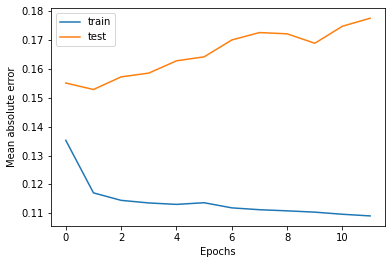

Root mean square error: 11417.4189453125
MAPE: 0.2743346374793961
MAE: 7670.610955613659
R2 score: 0.31702450232545454
 
 
---------------------------------------------------
Train on 35020 samples, validate on 600 samples
Epoch 1/100
35020/35020 [==============================] - 8s 233us/sample - loss: 0.1355 - val_loss: 0.1267
Epoch 2/100
35020/35020 [==============================] - 2s 64us/sample - loss: 0.1187 - val_loss: 0.1384
Epoch 3/100
35020/35020 [==============================] - 2s 62us/sample - loss: 0.1159 - val_loss: 0.1490
Epoch 4/100
35020/35020 [==============================] - 2s 61us/sample - loss: 0.1145 - val_loss: 0.1425
Epoch 5/100
35020/35020 [==============================] - 2s 64us/sample - loss: 0.1137 - val_loss: 0.1412
Epoch 6/100
35020/35020 [==============================] - 2s 61us/sample - loss: 0.1130 - val_loss: 0.1527
Epoch 7/100
35020/35020 [==============================] - 2s 65us/sample - loss: 0.1127 - val_loss: 0.1480
Epoch 8/100
35020/35

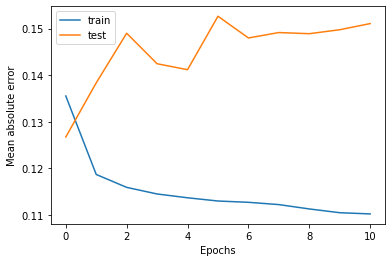

Root mean square error: 9762.2158203125
MAPE: 0.7047015502146738
MAE: 6359.570556640625
R2 score: -0.26533932703876495
 
 
---------------------------------------------------
Train on 35620 samples, validate on 620 samples
Epoch 1/100
35620/35620 [==============================] - 7s 201us/sample - loss: 0.1371 - val_loss: 0.0833
Epoch 2/100
35620/35620 [==============================] - 2s 68us/sample - loss: 0.1184 - val_loss: 0.0789
Epoch 3/100
35620/35620 [==============================] - 2s 66us/sample - loss: 0.1162 - val_loss: 0.0785
Epoch 4/100
35620/35620 [==============================] - 2s 65us/sample - loss: 0.1150 - val_loss: 0.0785
Epoch 5/100
35620/35620 [==============================] - 2s 68us/sample - loss: 0.1139 - val_loss: 0.0779
Epoch 6/100
35620/35620 [==============================] - 2s 69us/sample - loss: 0.1130 - val_loss: 0.0766
Epoch 7/100
35620/35620 [==============================] - 2s 68us/sample - loss: 0.1128 - val_loss: 0.0779
Epoch 8/100
35620/35

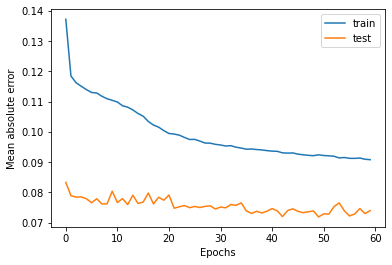

Root mean square error: 5482.359375
MAPE: 0.132677282176648
MAE: 3608.950357547883
R2 score: 0.4963696975662908
 
 
---------------------------------------------------


In [21]:
# Testing
# lag=14
ds=['october','november','december']

data_LSTM_X1,data_LSTM_X2,data_LSTM_Y = sequence_data_build(data, lag)
totday=int(data_LSTM_X1.shape[0]/20)
m1 = [totday-61, totday-31, totday, ]
m2 = [m1[0]-31, m1[1]-30, m1[2]-31, ]
for i in range(len(m1)):
    trainX1, trainY, testX1, testY= train_test_build(data_LSTM_X1, data_LSTM_Y, m1[i], m2[i])
    trainX2, trainY, testX2, testY= train_test_build(data_LSTM_X2, data_LSTM_Y, m1[i], m2[i])
    testYcopy=testY
    saving = True
    EarlyStop = True
    rmse, mape, mae, r2, history = model_build(trainX1, trainX2, testX1, testX2, trainY, testY, 64, saving, ds[i], EarlyStop)
        
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.xlabel("Epochs")
    pyplot.ylabel("Mean absolute error")
    pyplot.savefig("PM2F_" + ds[i] + ".png")
    pyplot.show()
    
    
    print("Root mean square error: {0}".format(rmse))
    print("MAPE: {0}".format(mape))
    print("MAE: {0}".format(mae))
    print("R2 score: {0}".format(r2))
    print(" ")
    print(" ")
    print("---------------------------------------------------")

In [19]:
print("lag vector")
print(lag_vec)
print("LSTM units")
print(units_vec)
print("Cross validation results")
print(lag,units)
print("----------------------------")
print("RMSE")
print(results[0,:])

print("----------------------------")
print("MAE")
print(results[1,:])

print("----------------------------")
print("MAPE")
print(results[2,:])

print("----------------------------")
print("R2-score")
print(results[3,:])

lag vector
[7, 14]
LSTM units
[2, 4, 8, 16, 32, 64, 128]
Cross validation results
14 128
----------------------------
RMSE
[[[5223.23974609 5183.72216797 4739.52490234 4682.44726562 6032.97949219
   4271.42431641 4328.53369141]
  [4798.86230469 5252.18505859 5409.08642578 5071.21826172 4350.84375
   4081.88354492 4087.23852539]]

 [[6483.26025391 5898.38232422 5968.90380859 5656.96289062 5200.71582031
   5088.54052734 4946.47509766]
  [5509.51171875 5435.91894531 5368.37011719 5527.95410156 5017.94042969
   4558.94287109 4398.53955078]]

 [[8033.62060547 7251.34179688 7423.62646484 7190.68261719 7042.26464844
   6943.33251953 6935.40673828]
  [6820.96728516 7052.44042969 6849.46875    6599.36914062 6602.51855469
   6552.71777344 6654.85253906]]]
----------------------------
MAE
[[[0.21876315 0.18891257 0.24406128 0.17137016 0.29816363 0.1337827
   0.12840522]
  [0.18041701 0.1922496  0.19597865 0.20177413 0.16011434 0.11450462
   0.12082384]]

 [[0.27918116 0.25648338 0.2772354  0.2453

In [20]:
print(MAE)

[[14260.39379185 13158.60129742 13124.97091566 12568.89592078
  12807.02210209 11221.54094813 11043.1789944 ]
 [12179.0973924  12720.01887483 12595.69670165 12443.88549679
  11066.9329683  10372.41874219 10334.91761222]]


In [ ]:
Root mean square error: 11242.35546875
MAPE: 0.2818463959398697
MAE: 7585.569150075605
R2 score: 0.33780802147786104
    
    Root mean square error: 9881.5869140625
MAPE: 0.6899350744815699
MAE: 6406.98930501302
R2 score: -0.29647326541825714
    
Root mean square error: 5494.4228515625
MAPE: 0.13161742438101248
MAE: 3545.5047709803425
R2 score: 0.4941508412434956